In [1]:
import numpy as np
import torch
import tqdm

from mol_utils import PotentialModel

In [2]:
from openmm import app
forcefield = app.ForceField('amber99sbildn.xml', 'tip3p.xml')

In [3]:
# The code below is taken from https://github.com/LarsHoldijk/SOCTransitionPaths/blob/master/plotting/PlotPathsAlanine.py
import numpy as np
import torch


class AlaninePotential():
    def __init__(self, granularity=90):
        super().__init__()
        self.granularity = granularity
        self.open_file()

    def open_file(self):
        file = "final_frame.dat"

        with open(file) as f:
            lines = f.readlines()

        dims = [self.granularity, self.granularity]

        self.locations = torch.zeros((int(dims[0]), int(dims[1]), 2))
        self.data = torch.zeros((int(dims[0]), int(dims[1])))

        i = 0
        for line in lines[1:]:
            # if line == '  \n':
            #     psi = psi + 1
            #     phi = 0
            #     continue
            splits = line[0:-1].split(" ")
            vals = [y for y in splits if y != '']

            x = float(vals[0])
            y = float(vals[1])
            val = float(vals[-1])

            self.locations[i // dims[1], i % dims[1], :] = torch.tensor([x, y])
            self.data[i // dims[1], i % dims[1]] = (val)  # / 503.)
            i = i + 1

    def potential(self, inp):
        loc = self.locations.view(-1, 2)
        distances = torch.cdist(inp, loc.double(), p=2)
        index = distances.argmin(dim=1)

        x = torch.div(index, self.locations.shape[0], rounding_mode='trunc')  # index // self.locations.shape[0]
        y = index % self.locations.shape[0]

        z = self.data[x, y]
        return z

    def drift(self, inp):
        loc = self.locations.view(-1, 2)
        distances = torch.cdist(inp[:, :2].double(), loc.double(), p=2)
        index = distances.argsort(dim=1)[:, :3]

        x = index // self.locations.shape[0]
        y = index % self.locations.shape[0]

        dims = torch.stack([x, y], 2)

        min = dims.argmin(dim=1)
        max = dims.argmax(dim=1)

        min_x = min[:, 0]
        min_y = min[:, 1]
        max_x = max[:, 0]
        max_y = max[:, 1]

        min_x_dim = dims[range(dims.shape[0]), min_x, :]
        min_y_dim = dims[range(dims.shape[0]), min_y, :]
        max_x_dim = dims[range(dims.shape[0]), max_x, :]
        max_y_dim = dims[range(dims.shape[0]), max_y, :]

        min_x_val = self.data[min_x_dim[:, 0], min_x_dim[:, 1]]
        min_y_val = self.data[min_y_dim[:, 0], min_y_dim[:, 1]]
        max_x_val = self.data[max_x_dim[:, 0], max_x_dim[:, 1]]
        max_y_val = self.data[max_y_dim[:, 0], max_y_dim[:, 1]]

        grad = -1 * torch.stack([max_y_val - min_y_val, max_x_val - min_x_val], dim=1)

        return grad

In [4]:
potential = AlaninePotential()

In [5]:
pot_model = PotentialModel([64, 64])

In [6]:
xs = np.arange(-np.pi, np.pi + .1, .05)
ys = np.arange(-np.pi, np.pi + .1, .05)
x, y = np.meshgrid(xs, ys)
inp = torch.tensor([x, y]).view(2, -1).T
true_vals = potential.potential(inp).float()
pot_model = PotentialModel([64, 64])
pot_opt = torch.optim.Adam(pot_model.parameters(), lr=1e-3)

n_pot_opt_steps = 8192

pbar = tqdm.tqdm(range(n_pot_opt_steps))
for i in pbar:
    preds = pot_model(inp.float())
    loss = ((true_vals - preds[:, 0]) ** 2).mean()
    pot_opt.zero_grad()
    loss.backward()
    pot_opt.step()
    pbar.set_postfix({"loss": loss.item()})

/var/folders/zv/qtb0nk453wd95ll0x83096j40000gp/T/ipykernel_33441/967823110.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  inp = torch.tensor([x, y]).view(2, -1).T
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8192/8192 [01:50<00:00, 74.04it/s, loss=1.4]


Text(0.5, 1.0, 'Approximate energy')

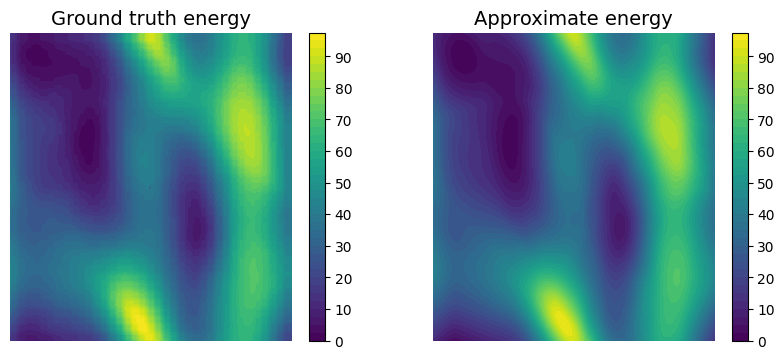

In [7]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

z = true_vals.detach()
z = z - z.min()
z = z.view(y.shape[0], y.shape[1])
im = ax1.contourf(xs, ys, z, levels=40, zorder=0)
fig.colorbar(im)
ax1.axis('off')
ax1.set_title("Ground truth energy", fontsize=14)

z = preds.detach()
z = z - z.min()
z = z.view(y.shape[0], y.shape[1])
im = ax2.contourf(xs, ys, z, levels=40, zorder=0)
fig.colorbar(im)
ax2.axis('off')
ax2.set_title("Approximate energy", fontsize=14)

In [8]:
# torch.save(pot_model.state_dict(), 'potential_model.pt')